In [1]:
import wandb
import os
import pickle
import shutil
from pathlib import Path
from typing import List, Union


def get_runs(user="", project="", query={}, **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    return runs
    #dataframes = [run.history(**kwargs) for run in runs]
    #return list(zip(runs, dataframes))

In [2]:
# CelebA
queries = {}

## Xent undersampled
queries["xent-undersampled"] = ("hashimoto-group",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-11-15_celeba_undersampled"]}},
             ]
})

## Poly loss
queries["poly"] = ("hashimoto-group",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-11-13_celeba_best_polyloss"]}},
              {"config.trainer/max_epochs": 200}
             ]
})

## VSLoss
queries["vs"] = ("hashimoto-group",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-11-11_vsloss_celeba"]}},
             ]
})

## Xent DRO
queries["xent-dro"] = ("hashimoto-group",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-11-13_celeba_dro_cross_entropy"]}},
             ]
})

## Poly loss DRO
queries["poly-dro"] = ("hashimoto-group",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-11-13_celeba_dro_compare_poly_loss"]}},
              {"config.loss_fn/alpha": 2}
             ]
})

## VSLoss DRO
queries["vs-dro"] = ("hashimoto-group",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-11-13_celeba_dro_vs_group_loss"]}},
             ]
})

In [35]:
def parse_run(run):
    config = run.config
    df = run.history(keys=["test/test_reweighted_acc", "test/worst_group_acc"])
    
    acc = df["test/test_reweighted_acc"].dropna().iloc[0] # there should only be one logged
    worst_acc = df["test/worst_group_acc"].dropna().iloc[0] # there should only be one logged
    assert acc > 0.
    stats = {
        "name": run.name,
        "loss": config["loss_fn/_target_"],
        "dataset": config["datamodule/group_datamodule_cls_name"],
        "seed": config["seed"],
        "acc": acc,
        "worst_acc": worst_acc,
    }
    return stats

In [36]:
stats_list = []
for query_name, user__query in queries.items():
    user, query = user__query
    project = "importance-reweighing"
    runs = get_runs(user=user, project=project, query=query)
    stats_of_runs = [parse_run(run) for run in runs]
    
    for stats in stats_of_runs:
        stats["query"] = query_name
    
    stats_list += stats_of_runs

In [37]:
import pandas as pd

df = pd.DataFrame(stats_list)

In [38]:
df.shape

(54, 7)

In [39]:
df.groupby("query").count()

,name,loss,dataset,seed,acc,worst_acc
query,,,,,,
poly,9,9,9,9,9,9
poly-dro,6,6,6,6,6,6
vs,9,9,9,9,9,9
vs-dro,10,10,10,10,10,10
xent-dro,10,10,10,10,10,10
xent-undersampled,10,10,10,10,10,10


In [8]:
df

,name,loss,dataset,seed,acc,query
0,frosty-valley-574,torch.nn.CrossEntropyLoss,CelebADataModule,1,0.831944,xent-undersampled
1,twilight-thunder-570,torch.nn.CrossEntropyLoss,CelebADataModule,7,0.838889,xent-undersampled
2,hearty-elevator-571,torch.nn.CrossEntropyLoss,CelebADataModule,6,0.751389,xent-undersampled
3,sandy-galaxy-572,torch.nn.CrossEntropyLoss,CelebADataModule,8,0.851389,xent-undersampled
4,mild-pyramid-569,torch.nn.CrossEntropyLoss,CelebADataModule,9,0.831944,xent-undersampled
5,northern-fog-573,torch.nn.CrossEntropyLoss,CelebADataModule,3,0.791667,xent-undersampled
6,crimson-lion-567,torch.nn.CrossEntropyLoss,CelebADataModule,5,0.826389,xent-undersampled
7,rural-tree-565,torch.nn.CrossEntropyLoss,CelebADataModule,0,0.858333,xent-undersampled
8,winter-fire-568,torch.nn.CrossEntropyLoss,CelebADataModule,2,0.838889,xent-undersampled
9,genial-spaceship-566,torch.nn.CrossEntropyLoss,CelebADataModule,4,0.809722,xent-undersampled


In [9]:
old_names = ['xent-undersampled', 'poly', 'vs', 'xent-dro', 'poly-dro', 'vs-dro']
new_names = ['CE+US', 'Poly+IW', "VS", "CE+DRO", "Poly+DRO", "VS+DRO"]
for old, new in zip(old_names, new_names):
    df["query"] = df["query"].replace(old, new)

In [10]:
import pandas as pd
df = pd.read_csv("sota-celeba-results.csv")

# Begin plots

In [22]:
import pandas as pd
df = pd.read_csv("sota-celeba-results.csv")

In [26]:
def get_corners(rectangle):
    b = rectangle
    w,h = b.get_width(), b.get_height()
    # lower left vertex
    x0, y0 = b.xy
    # lower right vertex
    x1, y1 = x0 + w, y0
    # top left vertex
    x2, y2 = x0, y0 + h
    # top right vertex
    x3, y3 = x0 + w, y0 + h
    return (x0,y0), (x1,y1), (x2,y2), (x3,y3)

In [27]:
def outline_bracket(left_bar, right_bar, spacing, height):
    l0, l1, l2, l3 = get_corners(left_bar)
    r0, r1, r2, r3 = get_corners(right_bar)
    
    # lower left
    b0 = ((l0[0] + l1[0]) / 2, max(l2[1], r2[1]) + spacing)
    # upper left
    b1 = (b0[0], max(l2[1] + spacing, r2[1] + spacing) + height)
    # upper right
    b2 = ((r0[0] + r1[0]) / 2, b1[1])
    # lower right
    b3 = (b2[0], b0[1])
    return b0, b1, b2, b3

## Interpolation results

In [28]:
df_interp = df.copy()

In [29]:
df_interp

,name,loss,dataset,seed,acc,query
0,frosty-valley-574,torch.nn.CrossEntropyLoss,CelebADataModule,1,0.831944,CE+US
1,twilight-thunder-570,torch.nn.CrossEntropyLoss,CelebADataModule,7,0.838889,CE+US
2,hearty-elevator-571,torch.nn.CrossEntropyLoss,CelebADataModule,6,0.751389,CE+US
3,sandy-galaxy-572,torch.nn.CrossEntropyLoss,CelebADataModule,8,0.851389,CE+US
4,mild-pyramid-569,torch.nn.CrossEntropyLoss,CelebADataModule,9,0.831944,CE+US
5,northern-fog-573,torch.nn.CrossEntropyLoss,CelebADataModule,3,0.791667,CE+US
6,crimson-lion-567,torch.nn.CrossEntropyLoss,CelebADataModule,5,0.826389,CE+US
7,rural-tree-565,torch.nn.CrossEntropyLoss,CelebADataModule,0,0.858333,CE+US
8,winter-fire-568,torch.nn.CrossEntropyLoss,CelebADataModule,2,0.838889,CE+US
9,genial-spaceship-566,torch.nn.CrossEntropyLoss,CelebADataModule,4,0.809722,CE+US


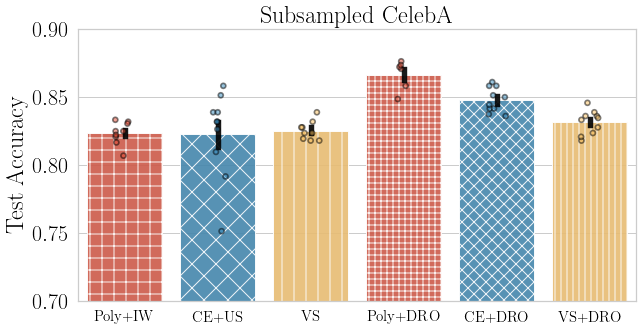

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

plt.rc('text', usetex=True)
plt.rc('font', family='times')
#palette = ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
palette = ['#E24A33', '#348ABD', '#FBC15E', '#E24A33', '#348ABD', '#FBC15E']
sns.set_palette(palette)

fig, ax = plt.subplots(figsize=(10, 5))
bar = sns.barplot(data=df_interp, x="query", y="acc", ax=ax, alpha=0.9, saturation=0.75, ci=68, errcolor=(0, 0, 0, 0.9),
                  order=['Poly+IW', 'CE+US', "VS", "Poly+DRO", "CE+DRO", "VS+DRO"])
sns.stripplot(data=df_interp, x="query", y="acc", ax=ax, alpha=0.5, dodge=True, edgecolor="black", linewidth=1.7,
              order=['Poly+IW', 'CE+US', "VS", "Poly+DRO", "CE+DRO", "VS+DRO"])
ax.set(ylim=[0.7, 0.9])
ax.set(title=r"Subsampled CelebA")
ax.set(ylabel=r"Test Accuracy")
ax.set(xlabel=None)
ax.set(xlabel=None)
ax.tick_params(axis='x', labelsize=15)

#bar.patches[0].set_hatch("+")
#bar.patches[0].set_edgecolor((1,1,1,1))
hatches = ["+","x","|", "++", "xx", "||"]
for i, b in enumerate(bar.patches):
    b.set_hatch(hatches[i])
    b.set_edgecolor((1, 1, 1, 1.))

# queries = [label.get_text() for label in ax.get_xticklabels()]
# queries.remove("poly")

# for i in range(len(queries)):
#     query = queries[i]
#     p_value = p_values[query]
#     if p_value < 0.05:
#         star = r"$**$" if p_value < 0.005 else r"$*$"

#         left_bar = bar.patches[i]
#         right_bar = bar.patches[i + len(queries)]
#         bracket = outline_bracket(left_bar, right_bar, spacing=0.02, height=0.005)
#         b_xs, b_ys = list(zip(*bracket))
#         ax.plot(b_xs, b_ys, c="k")
#         ax.text((b_xs[1] + b_xs[2]) / 2, b_ys[1] + 0.005, star, ha="center", va="bottom", color="k", fontsize=30)
        
# if cifar_p_value < 0.05:
#     star = r"$**$" if cifar_p_value < 0.005 else r"$*$"

#     left_bar = bar.patches[3]
#     right_bar = bar.patches[2]
#     bracket = outline_bracket(left_bar, right_bar, spacing=0.035, height=0.005)
#     b_xs, b_ys = list(zip(*bracket))
#     ax.plot(b_xs, b_ys, c="k")
#     ax.text((b_xs[1] + b_xs[2]) / 2, b_ys[1] + 0.005, star, ha="center", va="bottom", color="k", fontsize=30)    

# ax.set(xticklabels=["No IW", "IW ($\overline w$)", r"IW ($\overline w^{3/2})$"])  # Put at the end because p_values dict is named using old keys
# ax.set_axisbelow(True)

In [51]:
fig.savefig("sota-celeba.pdf", bbox_inches="tight")